In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pickle

In [3]:
house = pd.read_csv('kc_house_data_train.csv', index_col = 0)

In [4]:
house.shape

(17290, 21)

In [5]:
house['bedrooms'] = np.where(house['bedrooms'] != 33, house['bedrooms'], 3)

In [6]:
waterfronts = house[house['waterfront'] == 1][['lat', 'long']]

In [7]:
waterfronts.head(1)

,lat,long
67,47.3535,-122.323


In [ ]:
# water_lat = []

# for x in waterfronts['lat']:
#     water_lat.append(x)

# water_long = []

# for x in waterfronts['long']:
#     water_long.append(x)

In [ ]:
water_dist = []

In [ ]:
# for i in range(len(house['lat'])):
#     cmin = 100
#     for j in range(len(water_lat)):
#         c2 = np.sqrt((house['lat'][i] - water_lat[j])**2 + (house['long'][i] - water_long[j])**2)
#         if c2 < cmin:
#             cmin = c2
#     water_dist.append(cmin)

In [9]:
house['water_distance'] = water_dist

In [8]:
# with open('water_distance', 'wb') as handle:
#     pickle.dump(water_dist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('water_distance', 'rb') as handle:
    water_dist = pickle.load(handle)

In [ ]:
water_dist

In [ ]:
house.plot.scatter('water_distance', 'price')

# Creating log and sqrt to test the data

In [10]:
house['price_log'] = np.log(house['price'])

In [11]:
house['price_sqrt'] = np.sqrt(house['price'])

# Analyzing the data by numbers

In [ ]:
house.groupby('zipcode')['price'].describe().sort_values('mean', ascending = False)

In [ ]:
house.groupby('view')['price'].describe()

In [ ]:
house.groupby('grade')['price'].describe()

# EDA using graphs

In [ ]:
house.plot.scatter('sqft_living', 'price')

# standard linear regression

In [ ]:
house.plot.scatter('sqft_lot', 'price')

# ??? weird curve

In [ ]:
house.plot.scatter('floors', 'price')

In [ ]:
house.plot.scatter('bedrooms', 'price')

# ??? not sure what this could mean, possibly remove or group up 

In [ ]:
house.plot.scatter('bathrooms', 'price')

# fairly linear but still not a great indicator

In [ ]:
house.plot.scatter('view', 'price')

# view doesnt seem to have a great relation

In [ ]:
house.plot.scatter('grade', 'price')

# some linear relation but possibly a logistic relation 

In [ ]:
house.plot.scatter('condition', 'price')

# possibly groupy by 3 and higher or less than 3 since there is a big difference

In [ ]:
house.plot.scatter('yr_built', 'price')

In [ ]:
house.plot.scatter('yr_renovated', 'price')

In [ ]:
# for the year columns, we could add them together and put it as a column of years since last reno

In [ ]:
house.plot.scatter('sqft_above', 'price')

# very similar to sqft_living so possibly 

In [ ]:
house.plot.scatter('sqft_basement', 'price')

# some linearity but not very (possibly create a column of 0s and 1 to see 
# if they place has a basement and if there is any correlation)

# Creating a new columns for latest renovation

In [12]:
years_since_renovation = []
for i in range(len(house['yr_built'])):
    if house['yr_renovated'][i] > house['yr_built'][i]:
        years_since_renovation.append(2015 - house['yr_renovated'][i])
    else:
        years_since_renovation.append(2015 - house['yr_built'][i])

In [13]:
house['last_change'] = years_since_renovation

# Creating a column to practice on so we still have the original house data

In [14]:
practice = house

# Converting Basement sqft to a column of 1s and zeros for whether or not there is a basement

In [15]:
practice['basement'] = np.where(practice['sqft_basement'] > 0, 1, 0)

# items to remove
id

date

sqft_above

sqft_basement

sqft_living15

sqft_lot15

yr_built

yr_renovated

lat

long


# items to turn into dummies
view

condition

grade

zip code

# Dropping columns deemed unnecessary due to very low correlation

In [16]:
practice.drop(columns = ['id', 'date', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
              'yr_built', 'yr_renovated', 'lat', 'long', 'waterfront'], axis = 1, inplace = True)

# Creating dummy columns

In [17]:
zip_dummy = pd.get_dummies(practice['zipcode'], prefix = 'zip', drop_first = True)
view_dummy = pd.get_dummies(practice['view'], prefix = 'view', drop_first = True)
grade_dummy = pd.get_dummies(practice['grade'], prefix = 'grade', drop_first = True)
condition_dummy = pd.get_dummies(practice['condition'], prefix = 'condition', drop_first = True)

In [18]:
zip_dummy = zip_dummy[['zip_98004']]

In [19]:
grade_dummy.drop(columns=['grade_3', 'grade_4', 'grade_5', 'grade_8'], inplace=True)

In [20]:
view_dummy.drop(columns=['view_1'], inplace=True)

# Creating new df to include all dummies

In [21]:
full_practice = pd.concat([practice, zip_dummy, grade_dummy], axis = 1)

# full_practice = pd.concat([practice, zip_dummy, view_dummy, grade_dummy], axis = 1)

In [234]:
# lr_model = ols(formula = 'price~water_distance', data = full_practice).fit()
# lr_model.summary()

# Dropping extra columns that were made into dummies

In [22]:
full_practice.drop(columns = ['view', 'condition', 'grade', 'zipcode', 
                              'sqft_lot', 'bedrooms', 'bathrooms', 'floors'], axis = 1, inplace = True)

In [236]:
# Dropped sqft_lot as it was not a good indicator according to the model and correlation

In [237]:
# full_practice.corr()

# Making the features column

In [23]:
features_columns = []
for x in full_practice.columns:
    if 'price' not in x:
        features_columns.append(x)
    else:
        pass

# Removing all extreme values from the data set

In [239]:
def ext_values(df, extreme_cols):
    new_df = df.copy()
    for col in extreme_cols:
        std = new_df[col].std()
        mean = new_df[col].mean()
        value = mean+(5*std)
        new_df[col] = new_df[col].apply(lambda x: value if (np.abs(x-mean) > 5*std) else x)
    return new_df

In [240]:
full_practice = ext_values(full_practice, features_columns)

# Creating target variable and features

In [241]:
target = full_practice['price_log']
features = full_practice[features_columns]

# Train, test split on the target and features

In [242]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)  

# Scaling all the data using a standard scalar

In [215]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features_columns)
# X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features_columns)

# Standard linear regression using scikit

In [108]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = np.exp(lm.predict(X_train))

train_rmse = (np.sqrt(metrics.mean_squared_error((y_train), y_train_pred)))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = np.exp(lm.predict(X_test))

test_rmse = np.sqrt(metrics.mean_squared_error((y_test), y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', float(train_rmse), "vs. Testing: ", float(test_rmse))

Training Root Mean Squared Error: 609957.0148834775
Testing Root Mean Squared Error: 593948.5469034641
Training:  609957.0148834775 vs. Testing:  593948.5469034641


# Plotting Residuals to test

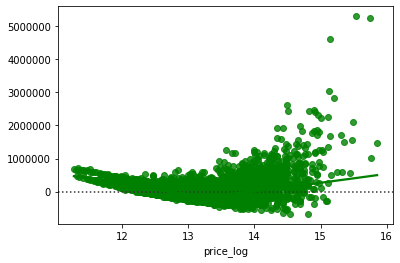

In [35]:
sns.residplot(y_train, y_train_pred,lowess=True, color="g")

# Applying recursive feature elimination

In [54]:
from sklearn.feature_selection import RFECV

In [55]:
ols = linear_model.LinearRegression()

In [56]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [57]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [58]:
list(removed_rfe)

[]

In [59]:
len(selected_rfe)

14

In [76]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_train_pred_rfe = np.exp(lm_rfe.predict(X_train[selected_rfe]))

train_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_rfe))


print('Training Root Mean Squared Error:' , train_rmse_rfe)

y_pred_rfe = np.exp(lm_rfe.predict(X_test[selected_rfe]))

test_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_test), y_pred_rfe))

print('Testing Root Mean Squared Error:' , test_rmse_rfe)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe))

Training Root Mean Squared Error: 597786.8373397781
Testing Root Mean Squared Error: 582231.6263031433
vs. Testing:  582231.6263031433 vs. Testing rfe:  582231.6263031433


In [ ]:
sns.residplot( y_train, y_train_pred_rfe,lowess=True, color="g")

# Applying Ftest selection

In [178]:
full_practice.columns

Index(['price', 'sqft_living', 'water_distance', 'price_log', 'price_sqrt',
       'last_change', 'basement', 'zip_98004', 'grade_6', 'grade_7', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13'],
      dtype='object')

In [156]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=10)

selector.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function f_regression at 0x10f74cf80>)

In [157]:
selected_ftest = X_train.columns[selector.get_support()]
removed_ftest = X_train.columns[~selector.get_support()]

In [158]:
list(removed_ftest)

['last_change', 'zip_98039', 'zip_98040', 'zip_98112', 'grade_13']

In [159]:
list(selected_ftest)

['sqft_living',
 'water_distance',
 'basement',
 'zip_98004',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12']

In [87]:
#instantiate a linear regression object
lm_ftest = LinearRegression()

#fit the linear regression to the data
lm_ftest = lm_ftest.fit(X_train[selected_ftest], y_train)

y_train_pred_ftest = np.exp(lm_ftest.predict((X_train[selected_ftest])))

train_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_ftest))


print('Training Root Mean Squared Error:' , train_rmse_ftest)

y_pred_ftest = np.exp(lm_ftest.predict((X_test[selected_ftest])))

test_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_test), y_pred_ftest))

print('Testing Root Mean Squared Error:' , test_rmse_ftest)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe),
      "vs. Testing ftest: ", float(test_rmse_ftest))

Training Root Mean Squared Error: 597786.8373397781
Testing Root Mean Squared Error: 582231.6263031433
vs. Testing:  582231.6263031433 vs. Testing rfe:  582231.6263031433 vs. Testing ftest:  582231.6263031433


In [ ]:
sns.residplot( y_train, y_train_pred_ftest,lowess=True, color="g")

# Applying lasso method

In [196]:
features.columns

Index(['sqft_living', 'water_distance', 'basement', 'zip_98004', 'grade_6',
       'grade_7', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13'],
      dtype='object')

In [197]:
from sklearn.linear_model import Lasso

In [244]:
lasso = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

final_lasso = lasso.fit(X_train,y_train)

y_train_pred_las = np.exp(lasso.predict(X_train))
y_pred_las = np.exp(lasso.predict(X_test))

train_rmse_las = metrics.mean_absolute_error(y_train, y_train_pred_las)
test_rmse_las = np.sqrt(metrics.mean_squared_error(y_test, y_pred_las))
print('Training Error: '+ str(train_rmse_las))
print('Testing Error: '+ str(test_rmse_las))

Training Error: 506061.92531171476
Testing Error: 562252.4790946662


In [246]:
# with open('final_lasso_lc', 'wb') as handle:
#     pickle.dump(final_lasso, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('final_lasso_lc', 'rb') as handle:
    finals_lasso = pickle.load(handle)

# my pickle of final_lasso includes the last_change column we created as a feature

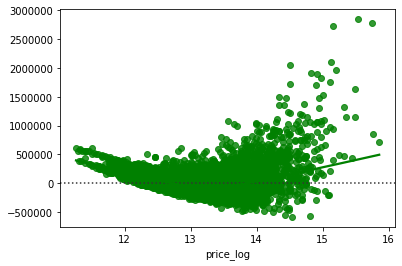

In [69]:
sns.residplot( y_train, y_train_pred_las,lowess=True, color="g")

In [247]:
finals_lasso(housin)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

# Attempting Variance Inflation Method

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [85]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(5).head(20)

,VIF Factor,features
0,1.12958,water_distance
1,1.41903,last_change
2,1.09319,basement
3,1.02540,zip_98004
4,1.02405,zip_98039
5,1.03366,zip_98040
6,1.02755,zip_98112
7,1.42390,grade_6
8,1.51982,grade_7
9,1.27762,grade_9


In [24]:
full_practice['price'].describe()

count    1.729000e+04
mean     5.407395e+05
std      3.733190e+05
min      7.500000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

# Fitting the Model

In [ ]:
final_scaler = StandardScaler()
final_scaler.fit_transform(features)

In [ ]:
final_model = LinearRegression()
final_model.fit(features, target)

In [ ]:
# houldout = pd.read_csv('whatever')

In [ ]:
# transformed_holdout = final_scaler(holdout)
# final_answers = final_model.predict(transformed_holdout)
# final_answers.to_csv('housing_preds_AHSR')